# Finding maxima using optimization

In [139]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import os
from pyphonon import *

# Check for GPU support
try:
    import cupy as cp
    import numpy as np
    GPU = True
    print(bcolors.OKGREEN+'GPU Support Enabled'+bcolors.ENDC)
except ImportError:
    import numpy as np
    GPU = False
    print(bcolors.WARNING+'Cupy Not available in your system. No GPU Support'+bcolors.ENDC)

# Ignore large warnings
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# Set some flags and environment variables
data_dir     = './data/'
fluid_dir    = 'fluids/'
particle_dir = 'particles/'

%matplotlib widget

Cupy Not available in your system. No GPU Support


In [140]:
# Create an estimator

# Simulator parameters
max_order   = 0
n_cores     = 20
slow        = False

# Create estimator
E = estimator(max_order=max_order,n_cores=n_cores,slow=slow,GPU=GPU)

Generating Estimator for order 0
Assembling the estimator using multiprocessing on 20 cores
Permuations created successfully
	Send the fast data to the pool
CUDA GPU Acceleration is unavailable for your system : (
	Fast: 0, 0 Done!
Pool closed Successfully
recasting functions


  0%|          | 0/1 [00:00<?, ?it/s]

Estimator Generated Successfully


In [141]:
# Simulation parameters
r   = 0.5
z   = 1.2
# t   = 
v   = 1.5
l   = 0.

# Estimator caller
p = lambda x: -E(r,x[1],x[0],v,l)

# Jacobian
JAC = E.get_jacobian()
jac = lambda x: -JAC(r,x[1],x[0],v,l)

# Define optimization constraints
constraints_ineq = {
    'type': 'ineq',
    'fun':  lambda x: np.array([-x[1] - r*np.sqrt(v**2-1) + v*x[0]]),
    'jac':  lambda x: np.array([v,-1]),
}

constraints_eq ={
    'type': 'eq',
    'fun':  lambda x: np.array([x[0]**2 + r**2/(1-v**2)]),
    'jac':  lambda x: np.array([2*x[0],0])
}

# res = minimize(p,x0,method='SLSQP',jac=jac,
#                 constraints=[constraints_ineq],options={'ftol': 1e-9, 'disp': True})

# Do the optimization
x0 = np.array([np.sqrt(r**2 + z**2),0])
res = minimize(p,x0,method='nelder-mead',
                options={'xatol': 1e-10, 'disp': True})
print(res)

Optimization terminated successfully.
         Current function value: -4731.885658
         Iterations: 154
         Function evaluations: 341
 final_simplex: (array([[0.66820193, 0.44328588],
       [0.66820193, 0.44328588],
       [0.66820193, 0.44328588]]), array([-4731.88565826, -4731.88565826, -4731.88565826]))
           fun: -4731.88565826416
       message: 'Optimization terminated successfully.'
          nfev: 341
           nit: 154
        status: 0
       success: True
             x: array([0.66820193, 0.44328588])


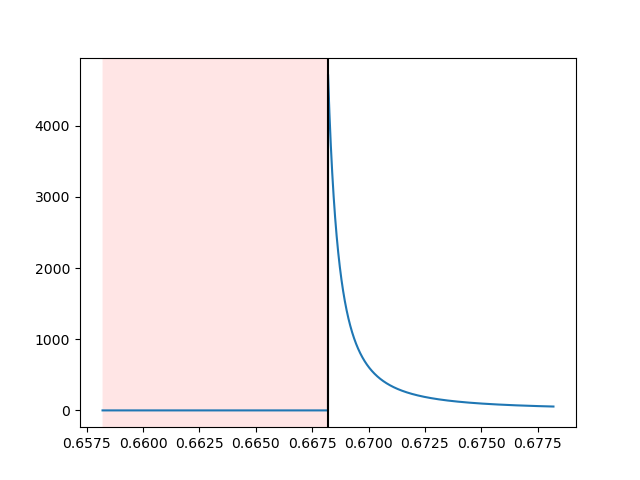

In [142]:
import matplotlib.transforms as mtransforms

fig = plt.figure()
ax  = fig.add_subplot(111)
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)

z   = res['x'][1]
t   = np.linspace(res['x'][0]-.01,res['x'][0]+.01,10000)
plt.plot(t,E(r,z,t,v,l))
plt.axvline(res['x'][0],c='k')
plt.fill_between(t,0,1,v*t - (z+r*np.sqrt(v**2-1)) < 0,
                facecolor='red',alpha=0.1,transform=trans)

In [143]:
# Calculate the maximum pressure given certain parameters
def max_pressure(R,V,l):
    # Array to store the final measurements
    fmax    = []
    pts     = []

    # For all the pairs 
    for r in tqdm(R):
        for v in tqdm(V):
            z   = 0.1

            # Estimator caller
            p = lambda x: -E(r,x[1],x[0],v,l)

            # Do the optimization
            x0 = np.array([np.sqrt(r**2 + z**2),0])
            res = minimize(p,x0,method='nelder-mead', options={'xatol': 1e-10, 'disp': True})
            fmax.append(-res['fun'])
            pts.append((r,res['x'][1],res['x'][0],v,l))

    return fmax, pts



In [146]:
# Collect the fluids and particles from the directories
fluid_files     = [data_dir+fluid_dir+f for f in os.listdir(data_dir+fluid_dir)]
fluid_names     = [f.replace('.txt','') for f in os.listdir(data_dir+fluid_dir)]
particle_files  = [data_dir+particle_dir+f for f in os.listdir(data_dir+particle_dir)]
particle_names  = [f.replace('.txt','') for f in os.listdir(data_dir+particle_dir)]
fluids          = [fluid(fname,name=n) for fname,n in zip(fluid_files,fluid_names)] 
particles       = [particle(fname,name=n) for fname,n in zip(particle_files,particle_names)]